# <center>Telegram Group Analysis

We want to explore, visualize and analyze the activity in a Telegram group over last two years. With the telephon library we extract the posts, comments and users and create three seperate tables to structure that information.
As input we choose the group "Corona_ist_nicht_das_Problem" and we want look at the date from the last two years.

In [ ]:
# we import the necessary libraries

import asyncio
import time
import datetime
from datetime import datetime
from datetime import timezone
import nest_asyncio
nest_asyncio.apply()


from telethon import TelegramClient
from telethon import functions, types
from telethon.errors import SessionPasswordNeededError
from telethon.tl.functions.channels import GetParticipantsRequest,GetAdminLogRequest
from telethon.tl.types import ChannelParticipantsSearch
from telethon.tl.types import (
    PeerChannel
)
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (
PeerChannel
)

import configparser

#### **Here we create a client to call the API.**

In [ ]:
# here we need our API access information

api_id = XXXXXXXXX
api_hash = 'XXXXXXXXXXXXXXXXXXXX'

phone = 'XXXXXXXXXXXXX'
username = 'XXXXXXXXXXXX'

# we create the API client and connect

client = TelegramClient(username, api_id, api_hash)

async def main(phone):
    await client.start()
    print("Client Created")
    
    if await client.is_user_authorized() == False:
        
        await client.send_code_request(phone)
        try:
            await client.sign_in(phone, input('Enter the code: '))
        except SessionPasswordNeededError:
            await client.sign_in(password=input('Password: '))

    me = await client.get_me()

    user_input_channel = input("enter entity(telegram URL or entity id):")
    

    if user_input_channel.isdigit():
        entity = PeerChannel(int(user_input_channel))
    else:
        entity = user_input_channel

    my_channel = await client.get_entity(entity)  

    offset_id = 0    
    
    all_history = []
    all_user_details = []
    comments =[]
    postlist = [] 
    userlist = []     

    index = 0
    round=0    
    
    
    curr_max_id = 0
    stop=0
    limit = 10
    no_data = False
    
    stop_date = datetime.datetime(2030, 1, 1)
    start_date = datetime.datetime(2021, 1, 1)
    end_date = datetime.datetime(2022, 12, 3)   
    
    
    while True:
     stop +=1
     print(stop_date)
     
     if no_data==True:
         print('no data')
         break
     
     elif start_date > stop_date:
         print('date limit')
         break    
     
     else:       
             
        history = await client(GetHistoryRequest(
            my_channel,
            offset_id=curr_max_id,
            offset_date=end_date,
            add_offset=0,
            limit=limit,
            max_id=0,
            min_id=0,
            hash=0
            ))         
    
          
        all_history =history.messages
        
        for message in all_history:
          all_user_details.append(message.to_dict())
        
        
        if len(all_user_details)%limit==0: 
          message = all_user_details[-1]         
             
          try:
                index = int(message.get('id'))  
                if index ==  curr_max_id:
                    no_data = True 
                else:
                    stop_date = message.get('date')
                    stop_date =stop_date.replace(tzinfo=None)
                    
                    curr_max_id = index        
                
          except:
               print('no ID')                                    
                                
    print('get comments')           
    for message in all_user_details:
          
    
        if message.get('id') != None:
            post = int(message.get('id'))
            
            postlist.append(post)  
    
        try:
            async for message in client.iter_messages(entity, reply_to=post):
                comments.append(message.to_dict())
                userid = message.to_dict()
                userid = userid['from_id'].get('user_id')
                result = await client(functions.users.GetUsersRequest(
                    id= [userid]))
                for x in result:
                    userlist.append(x.to_dict())
        except:
            None
        round +=1
        print(round)
    
        
    return all_user_details, comments, postlist, userlist
     
  

async with client:
    message_list,comment_list,post_list,user_list = client.loop.run_until_complete(main(phone))
  


## **Creation of the dataframes**




In [ ]:
# create post dataframe

post_df = pd.DataFrame.from_dict(message_list)
post_df = post_df[['id','date','peer_id', 'reply_to', 'message', 'media']]
post_df['Channel ID'] = post_df['peer_id'].apply(lambda x: str(x.get('channel_id')) if x != None else x)
post_df.drop('peer_id', inplace = True, axis = 1)

post_df.head()

,id,date,reply_to,message,media,Channel ID
0,3960,2022-12-02 18:41:33+00:00,NaN,Faktenverzerrung beim Deutschlandfunk – Bewuss...,"{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",1339253689
1,3959,2022-12-02 09:14:01+00:00,NaN,Wo bleibt die Entschuldigung & warum sind die ...,"{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",1339253689
2,3958,2022-12-01 14:27:04+00:00,NaN,Mimikama veröffentlicht brisanten Faktencheck ...,"{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",1339253689
3,3957,2022-11-30 11:20:52+00:00,NaN,MDR berichtet über Todesfall nach der 3. Impfu...,"{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",1339253689
4,3956,2022-11-29 23:35:54+00:00,NaN,Tagesschau: »Warum ist die Übersterblichkeit s...,"{'_': 'MessageMediaWebPage', 'webpage': {'_': ...",1339253689


In [ ]:
# create comments dataframe

comment_df = pd.DataFrame.from_dict(comment_list)
comment_df= comment_df[['id','date','from_id', 'message', 'reply_to']]
comment_df = comment_df.rename(columns={'id': 'Comment ID','date': 'Datum','from_id': 'Nutzer ID', 'message': 'Kommentar'})
comment_df['Nutzer ID'] = comment_df['Nutzer ID'].apply(lambda x: str(x.get('user_id')) if x != None else x)
comment_df['Antwort auf Message ID'] = comment_df['reply_to'].apply(lambda x: str(x.get('reply_to_msg_id')) if x != None else x)
comment_df['Antwort auf TOP ID'] = comment_df['reply_to'].apply(lambda x: str(x.get('reply_to_top_id')) if x != None else x)
comment_df.drop('reply_to', inplace = True, axis = 1)

comment_df.head()

,Comment ID,Datum,Nutzer ID,Kommentar,Antwort auf Message ID,Antwort auf TOP ID
0,136849,2022-12-03 11:58:12+00:00,1154002207,Glückwunsch! Seit ich vor 40 Jahren feste4gest...,136840,136832
1,136842,2022-12-03 06:50:53+00:00,1333072004,NaN,136832,None
2,136840,2022-12-03 06:50:19+00:00,1333072004,Ja wirklich sehr Schade das die guten Ärzte au...,136832,None
3,136838,2022-12-03 04:13:34+00:00,1154002207,Ihnen auch viele Grüsse! Meine Mutter hat nach...,136837,136832
4,136837,2022-12-02 21:13:59+00:00,1333154660,In der DDR wurden wir alle durchgeimpft. Ich s...,136835,136832


In [ ]:
import pandas as pd

# create user dataframe

user_df = pd.DataFrame.from_dict(user_list)
user_df = user_df[['id','first_name','last_name', 'username', 'phone', 'bot']]

unique_df = pd.DataFrame()
user_df.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index = True)


def mask_values(val):
    return f"opacity: {0}"

user_filtered = user_df.iloc[10:15,:]

hidden_user_df= user_filtered.style.applymap(
    mask_values,
    subset=(
        user_filtered.index,
        ["last_name", 'username']))

# we hide the values in the 'last_name' column   
hidden_user_df

# alternative for GitHub
user_filtered[['id','first_name', 'bot']]

,id,first_name,bot
10,5703191181,MozZi,False
11,124798832,B,False
12,1947115682,Güni,False
13,1133893586,max,False
14,2064704589,Heike,False


## **Text Processing**

We filter for characters and stopwords and save the output in the column 'comment clean' for further analysis.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
nltk.download('punkt')
nltk.download('stopwords')


stop_words = set(stopwords.words("german"))


def clean_text(text):
   
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]
      
    words_filtered = [
        word for word in words_tokens_lower if word not in stop_words
    ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [ ]:
comment_df=comment_df.dropna()
comment_df["comment_clean"] = comment_df.Kommentar.map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)

In [ ]:
comment_df.head()

,Comment ID,Datum,Nutzer ID,Kommentar,Antwort auf Message ID,Antwort auf TOP ID,Tag_Monat_Jahr,comment_clean
0,136849,2022-12-03 11:58:12+00:00,1154002207,Glückwunsch! Seit ich vor 40 Jahren feste4gest...,136840,136832,2022-12-03,glückwunsch seit jahren feste gestellt kranken...
2,136840,2022-12-03 06:50:19+00:00,1333072004,Ja wirklich sehr Schade das die guten Ärzte au...,136832,None,2022-12-03,ja wirklich schade guten ärzte aussterben seit...
3,136838,2022-12-03 04:13:34+00:00,1154002207,Ihnen auch viele Grüsse! Meine Mutter hat nach...,136837,136832,2022-12-03,viele grüsse mutter überstandenen kinderkrankh...
4,136837,2022-12-02 21:13:59+00:00,1333154660,In der DDR wurden wir alle durchgeimpft. Ich s...,136835,136832,2022-12-02,ddr wurden durchgeimpft sehe schule schlange s...
5,136835,2022-12-02 20:27:18+00:00,1154002207,"Mein Impfbuch ist fast leer. Masern, Mumps, Rö...",136834,136832,2022-12-02,impfbuch fast leer masern mumps röteln windpoc...


## **Visualization of word frequency**

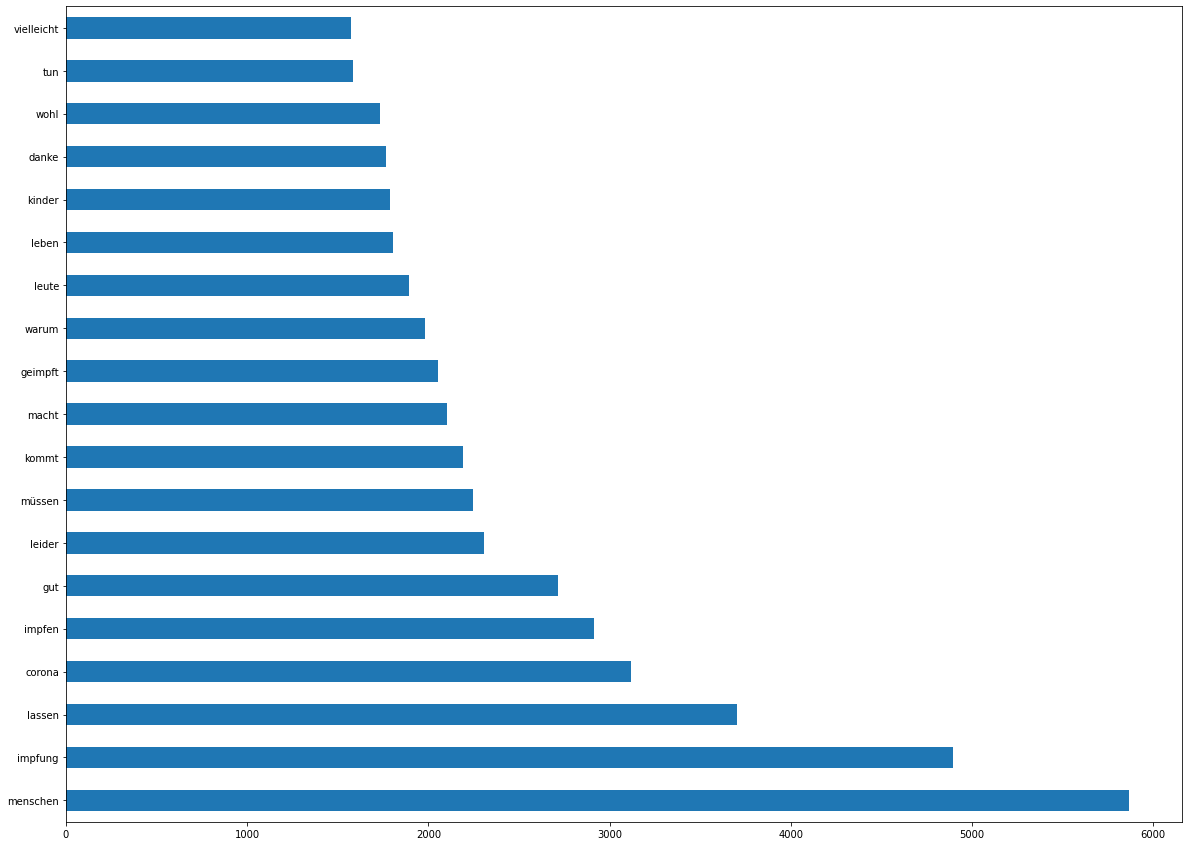

In [ ]:
import matplotlib.pyplot as plt

# we filter for some addional words despite the stopwords in the blacklist

blacklist = ['viele', 'tut', 'mal', 'ab', 'mehr', 'schon','https','wer','gibt','ganz', 'de', 'gar', 'immer', 'einfach', 'geht', 'www', 'erst','genau',
             'wurde','wirklich', 'gehen', 'seit','hätte','wäre','nie','klar']

word_freq = pd.Series(" ".join(comment_df["comment_clean"]).split()).value_counts()

plt.figure(figsize=(20,15))

# we display the 20 most frequent words that are not in our blacklist
word_freq = word_freq.loc[lambda x : ~x.index.isin(blacklist)]
word_freq[1:20].rename("Word frequency of most common words in comments").plot(kind='barh')

## **Wordcloud of the most frequent words**

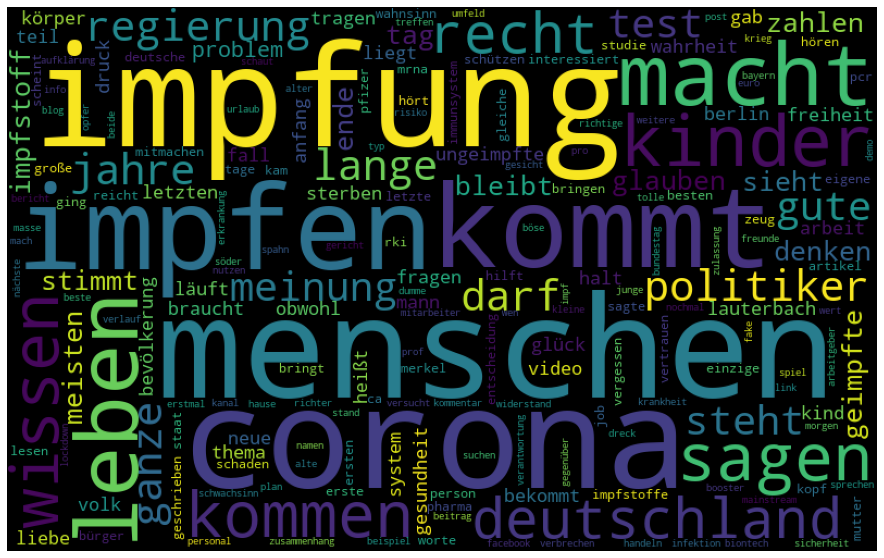

In [ ]:
from wordcloud import WordCloud

def create_wordcloud(text):    
    allWords = ' '.join([tweets for tweets in text])
    wordCloud = WordCloud(background_color='black', width=800, height=500, random_state=21, max_font_size=130, mode="RGBA").generate(allWords)
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()
    print('')



words = [x for x in word_freq.index]

create_wordcloud(words)

## **Overall activity in the group**

<ipython-input-40-b1fee14e9252>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_df['Monat_Jahr']=comment_df['Datum'].apply(lambda x: x.strftime('%Y-%m'))


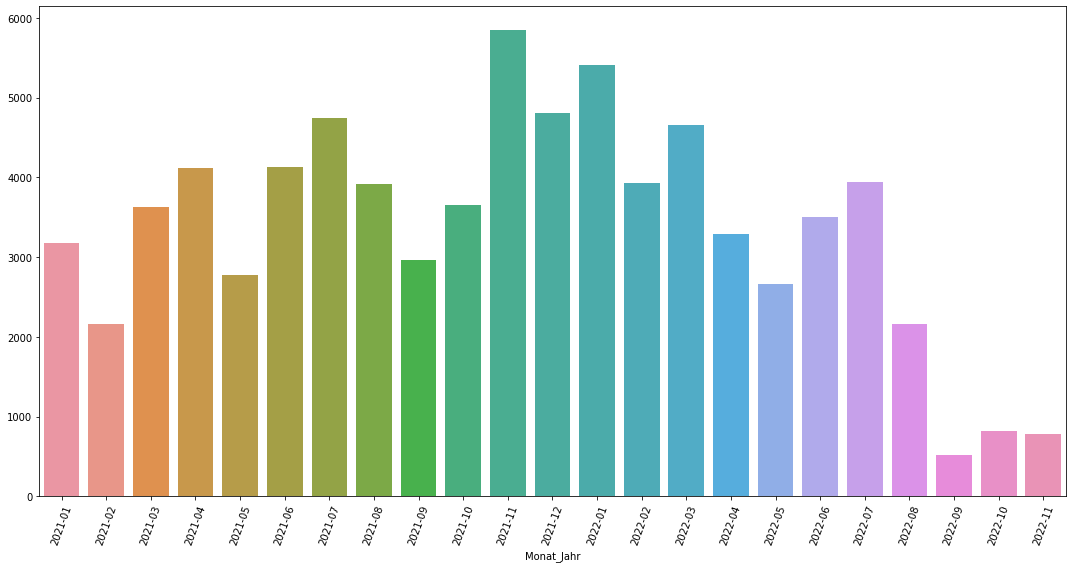

In [ ]:
import seaborn as sns

comment_df['Monat_Jahr']=comment_df['Datum'].apply(lambda x: x.strftime('%Y-%m'))
message_count = comment_df['Kommentar'].groupby(comment_df['Monat_Jahr']).count()

plt.figure(figsize=(15, 8))
sns.barplot(x = message_count.index[1:-1], y = message_count.values[1:-1] )
plt.xticks(rotation=70)
plt.tight_layout()


## **Users who use the word 'Klabauterbach' most often**

In [ ]:
word = 'labauterbach'
get_comments = comment_df['Kommentar'].str.match(f'[^.]*{word}[^.]*\.')

df=pd.DataFrame(comment_df[['Nutzer ID', 'Kommentar']][get_comments])
print(f' The word "{word}"" was used {df.shape[0]} times')
df.head()

 The word "labauterbach"" was used 31 times


,Nutzer ID,Kommentar
869,2021421583,"Wenn der Klabauterbach sagt, es sind keine Sch..."
895,1271696580,"so einfach ist das nicht, Klabauterbach hat si..."
2318,1231677043,Beim Klabauterbach ist das Hirn schon längst a...
2420,1231677043,Bei Klabauterbach ist das Hirn längst abgestor...
2453,576035371,Lacht die Idioten Klabauterbach und Co. doch e...


In [ ]:
df=pd.DataFrame(comment_df[['Nutzer ID','Kommentar']][get_comments].\
    groupby(['Nutzer ID'])['Kommentar'].count().nlargest(5).reset_index())
df

,Nutzer ID,Kommentar
0,1080583133,2
1,1231677043,2
2,1271696580,2
3,1441678540,2
4,5084028380,2


In [ ]:
import numpy as np

# we merge the the created 'df' table with our user_df table in the id to get more infomrmation

df['Nutzer ID']=df['Nutzer ID'].astype(np.int64)
merge_df = pd.merge(df['Nutzer ID'], user_df, left_on='Nutzer ID', right_on='id', how='left')
merge_df = merge_df.drop(['id'], axis = 1)


## **Activity of the user with the most comments**

In [ ]:
df = pd.DataFrame()
df['id'], df['count'] = comment_df['Nutzer ID'].value_counts().index[0:5].astype(np.int64),comment_df['Nutzer ID'].value_counts().values[0:5]
df

,id,count
0,5049542692,1239
1,1503570755,690
2,1880399828,631
3,1947115682,607
4,226736826,430


In [ ]:
merge_df = pd.merge(df, user_df, left_on='id', right_on='id', how='left')
merge_df

,id,count,first_name,last_name,username,phone,bot
0,5049542692,1239,Ivana,NaN,NaN,NaN,False
1,1503570755,690,JulS,NaN,JulS1897Ju,NaN,False
2,1880399828,631,Sabine,No,Sabine363,NaN,False
3,1947115682,607,Güni,B.,NaN,NaN,False
4,226736826,430,Mikel Jay,NaN,NaN,NaN,False


Text(0.5, 1.0, 'Comments fro user ID 5049542692')

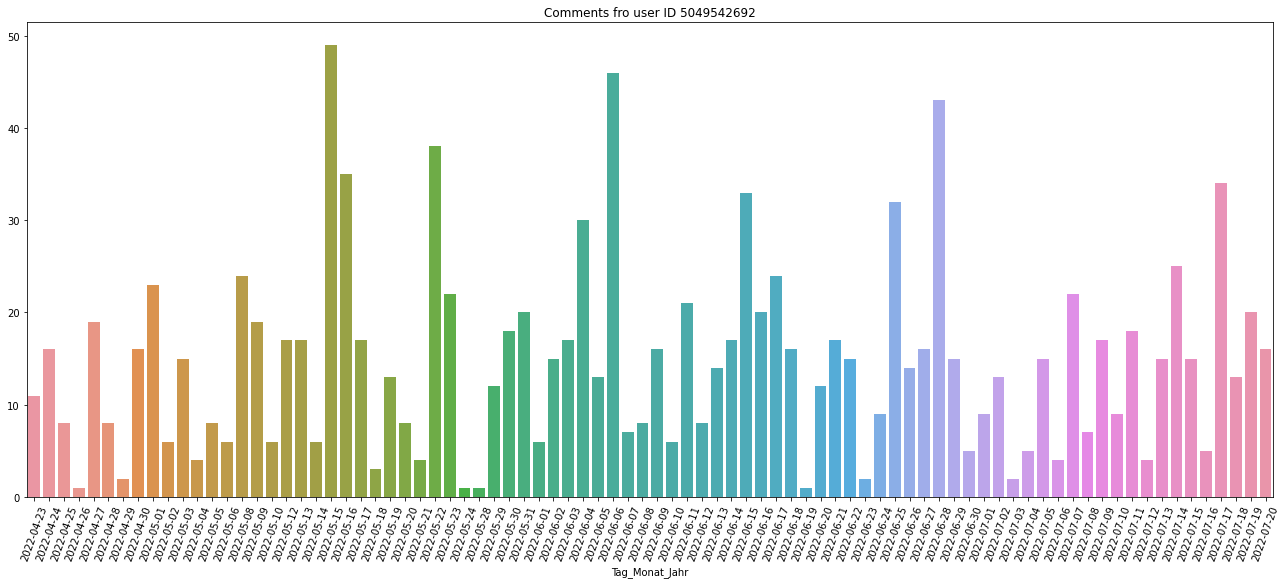

In [ ]:
comment_df['Tag_Monat_Jahr']=comment_df['Datum'].apply(lambda x: x.strftime('%Y-%m-%d'))

top_user = merge_df.id[0]
message_count = comment_df['Kommentar'].loc[comment_df['Nutzer ID'] == str(top_user)].groupby(comment_df['Tag_Monat_Jahr']).count()

plt.figure(figsize=(18, 8))
sns.barplot(x = message_count.index, y = message_count.values )
plt.xticks(rotation=70)
plt.tight_layout()
plt.title(f'Comments fro user ID {top_user}')